# Data Inspection and Visualization
This notebook looks at cutouts stored in a mongoDB database. Specifically we explore the collected stats and distribution of data based on these stats.

In [1]:
# import modules
import sys
sys.path.append("..")
from mongo_utils import Connect
import pymongo
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from datasets import Cutout
from dataclasses import dataclass, field
from typing import List
import uuid

import dataframe_image as dfi

## Connect to DB and Prep data for Inspection

### Connect to database, Query collection, and Convert to Pandas DF

In [3]:
"""Connect to database and read contents for use."""
connection = Connect.get_connection()
db = connection.trial
cursor = db.Cutouts.find()
data = pd.DataFrame(list(cursor))

### Turn nested "stats" dictionaries into columns and change data types

In [4]:
df = pd.concat([data.drop(['stats'], axis=1), data['stats'].apply(pd.Series)], axis=1)
# Only change certain column data types
cols_to_norm = ['area','area_bbox', 'area_convex', 'eccentricity', 'extent', 'perimeter', 'solidity']
df[cols_to_norm] = df[cols_to_norm].astype("float")

### (Experimental) Create New DF with normalized stat data columns

In [5]:
ndf = df.copy()
cols_to_norm = ['area','area_bbox', 'area_convex', 'eccentricity', 'extent', 'perimeter', 'solidity']
ndf[cols_to_norm] = ndf[cols_to_norm].apply(lambda x: (x - x.min()) / (x.max() - x.min()))

### Split "image_id" to create "row" and "stop" columns


In [6]:
df['image_id'] = df['image_id'].str.lower()
df[["row","stop"]] = df["image_id"].str.split("_", expand=True)

## Inspect DF

In [7]:
df.sort_values("date").head()


,_id,cutout_path,cutout_num,image_id,site_id,date,cutout_id,species,days_after_planting,area,...,axis_minor_length,centroid-0,centroid-1,eccentricity,extent,solidity,label,perimeter,row,stop
0,625e0e66597287e50e5dd4f0,Row1_1_0.png,0,row1_1,NC,2022-03-04,e8e33b7d-ef1e-4667-a58c-a710877ba903,None,14,674410.0,...,983.728908084358,871.8158657196661,907.2231194673863,0.744318,0.408931,0.595573,1,6895.852665,row1,1
158,625e1003597287e50e5dd59c,Row5_3_6.png,6,row5_3,NC,2022-03-04,400511a4-be4e-462c-8267-a5c8fbaec58c,None,14,194.0,...,7.688316057284583,383.1082474226804,1066.6443298969073,0.975762,0.568915,0.779116,1,77.012193,row5,3
159,625e1003597287e50e5dd59d,Row5_3_7.png,7,row5_3,NC,2022-03-04,5b6ce23a-9cce-4149-a5af-4d5e0fe6a45f,None,14,78.0,...,7.356076465418509,388.21794871794873,1094.9615384615386,0.839675,0.666667,0.906977,1,32.970563,row5,3
160,625e1003597287e50e5dd59e,Row5_3_8.png,8,row5_3,NC,2022-03-04,c1ac6fc5-fc58-404e-a5cb-ef5510c11a4a,None,14,181.0,...,8.062141935471836,398.4640883977901,1140.3204419889503,0.968600,0.430952,0.808036,1,71.254834,row5,3
161,625e1003597287e50e5dd59f,Row5_3_9.png,9,row5_3,NC,2022-03-04,a9c2e06a-99eb-4012-b413-61efa9351766,None,14,1061.0,...,16.644522055369727,467.8953817153629,928.4806786050896,0.980702,0.467813,0.883430,1,198.166522,row5,3


## Totals and stats

In [8]:
# Number of images per batch
gdf = data.groupby(['date'], as_index=False)["image_id"].nunique()
print("\nNumber of images per batch")
print(gdf)
# Number of cutouts per batch

gdf = data.groupby(['date'], as_index=False)["cutout_id"].count()
print("\nNumber of cutouts per batch")
print(gdf)

# Number of cutouts per image
gdf = data.groupby(['date', 'image_id'], as_index=False)["cutout_num"].count()
print("\nNumber of cutouts per image")
# print(gdf)


Number of images per batch
         date  image_id
0  2022-03-04        18
1  2022-03-11        48
2  2022-03-22        24
3  2022-03-29        37
4  2022-04-05        29
5  2022-04-12        36

Number of cutouts per batch
         date  cutout_id
0  2022-03-04        249
1  2022-03-11        593
2  2022-03-22        295
3  2022-03-29        660
4  2022-04-05        507
5  2022-04-12        788

Number of cutouts per image


## Distribution of Cutouts by BBot Position

<Figure size 2448x1296 with 0 Axes>

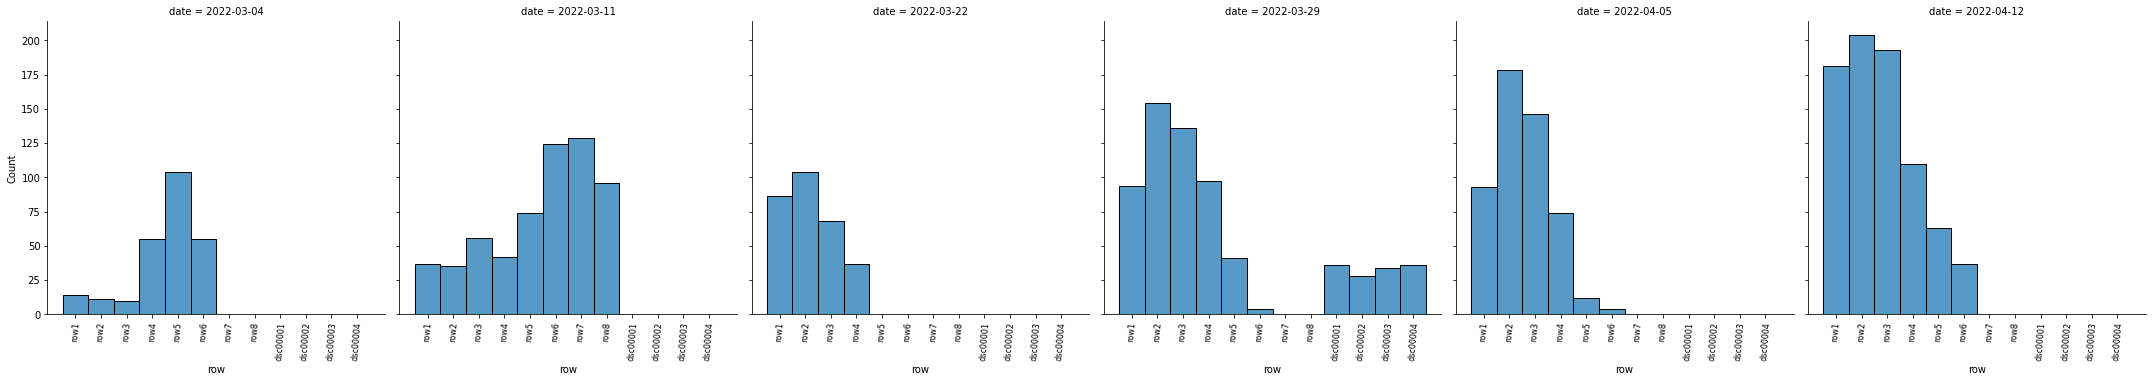

In [9]:
# plt.style.use('seaborn-dark')
# params = {"ytick.color" : "w",
#           "xtick.color" : "w",
#           "axes.labelcolor" : "w",
#           "axes.edgecolor" : "w"}
# plt.rcParams.update(params)

df = df[~df['image_id'].astype(str).str.startswith('DSC')]
df = df[df["date"]!="Test"]
plt.figure(figsize=(34,18))
g = sns.displot(df,x="row", col="date")
g.set_xticklabels(rotation=85, fontsize=8)
# plt.savefig("dist_by_date.png", dpi=300, format="png", transparent=True)

/tmp/ipykernel_18881/2336782892.py:27: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_yticklabels(im.get_yticks(), size =ticklabelfontsize)
/tmp/ipykernel_18881/2336782892.py:28: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(im.get_xticks(), size =ticklabelfontsize)
/tmp/ipykernel_18881/2336782892.py:34: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_yticklabels(im.get_yticks(), size =ticklabelfontsize)
/tmp/ipykernel_18881/2336782892.py:35: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_xticklabels(im.get_xticks(), size =ticklabelfontsize)
/tmp/ipykernel_18881/2336782892.py:41: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax3.set_yticklabels(im.get_yticks(), size =ticklabelfontsize)
/tmp/ipykernel_18881/2336782892.py:42: UserWarning: FixedFormatter should only be used together with FixedLoca

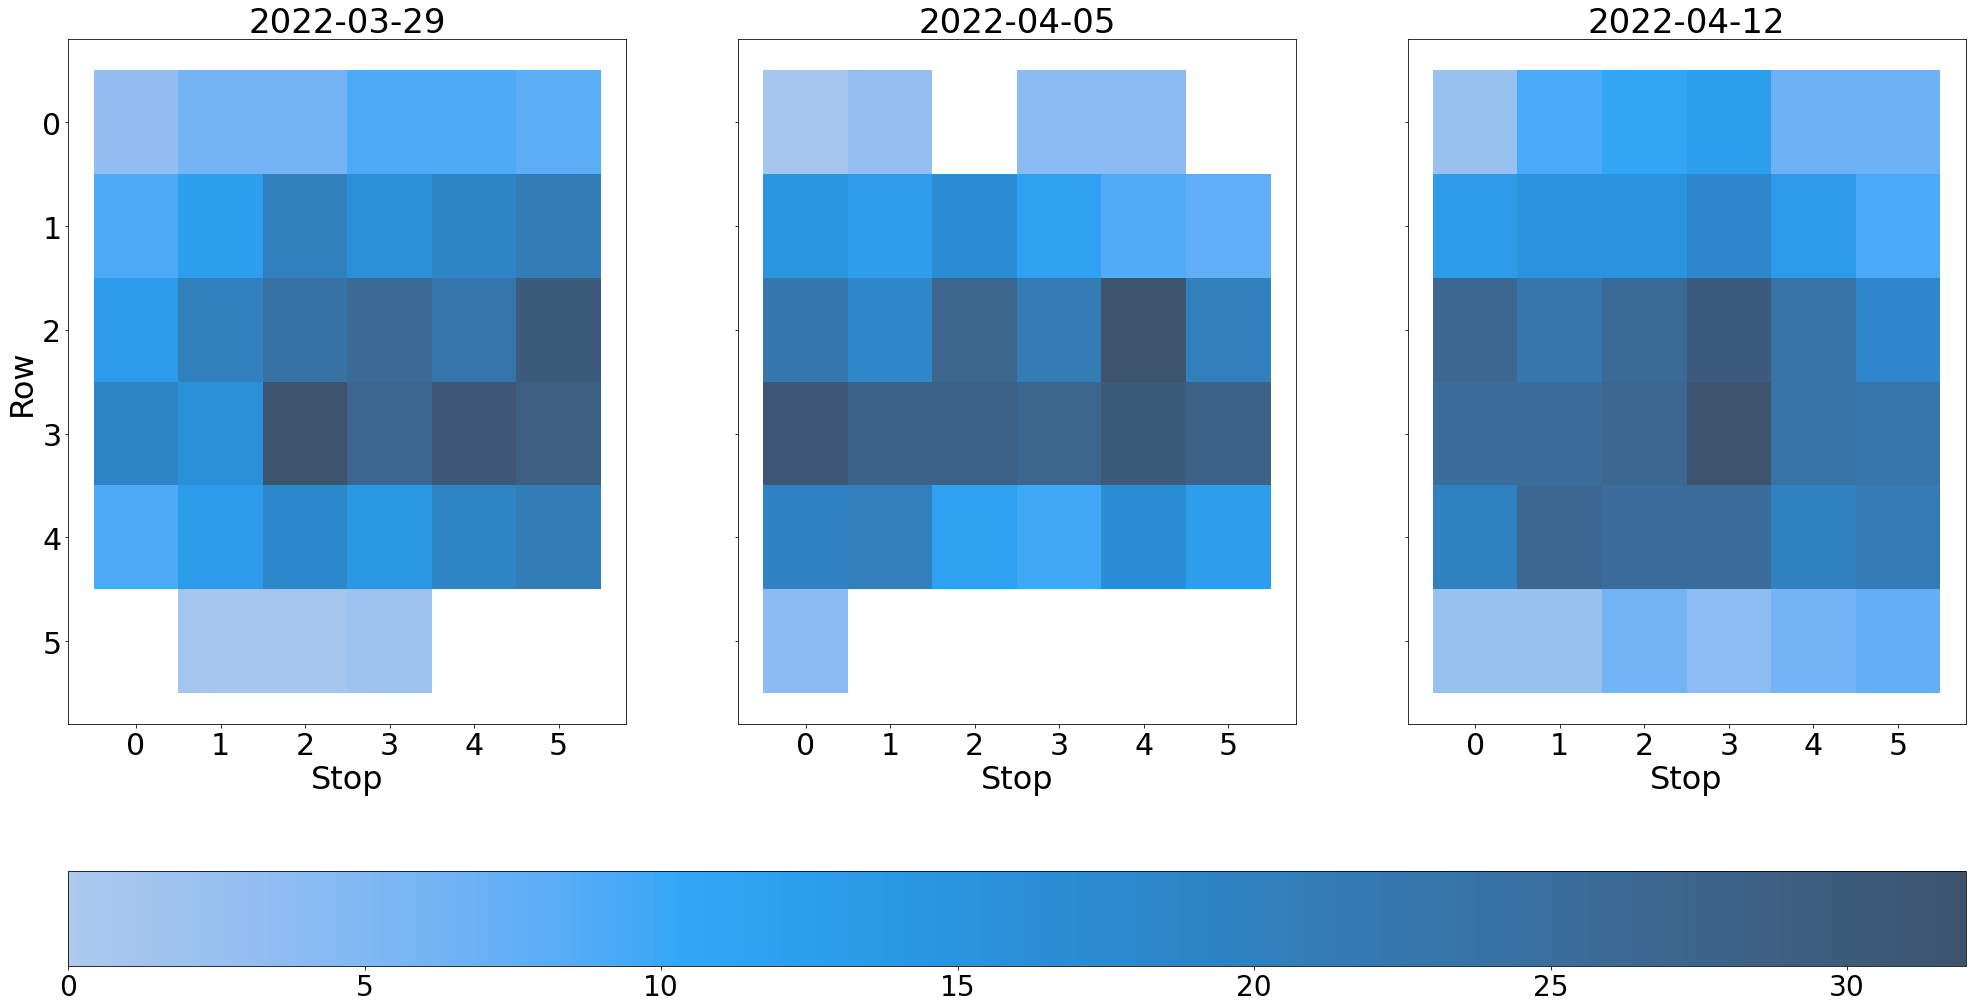

In [11]:
# df["row"] = df["row"].str.replace("row","").astype("int")
# df["row"] = df["row"].astype("int")
# df["stop"] = df["stop"].astype("int")

# plt.style.use('seaborn-dark')
# params = {"ytick.color" : "w",
#           "xtick.color" : "w",
#           "axes.labelcolor" : "w",
#           "axes.titlecolor" : "w",
#           "axes.edgecolor" : "w"}
# plt.rcParams.update(params)

titlefontsize=34
axislabefontsize= 32
ticklabelfontsize=30
cbarfontsize = 28

cols_to_norm = ['area','area_bbox', 'area_convex', 'eccentricity', 'extent', 'perimeter', 'solidity']
df[cols_to_norm] = df[cols_to_norm].astype("float")
# plt.figure(figsize=(34,18))
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(34, 18))
# set facecolor black for testing:
# fig.set_facecolor("k")
im = sns.histplot(df[df["date"]=="2022-03-29"].sort_values(["stop","row"], ascending=(True, False)), x="stop", y="row", cbar=False,ax=ax1)#,col_order=["2022-03-29", "2022-04-05", "2022-04-12"])
ax1.set_ylabel('')    
ax1.set_xlabel('')
ax1.set_yticklabels(im.get_yticks(), size =ticklabelfontsize)
ax1.set_xticklabels(im.get_xticks(), size =ticklabelfontsize)
ax1.set_title('2022-03-29', fontsize=titlefontsize)

sns.histplot(df[df["date"]=="2022-04-05"].sort_values(["stop","row"], ascending=(True, False)), x="stop", y="row", cbar=False,ax=ax2)#,col_order=["2022-03-29", "2022-04-05", "2022-04-12"])
ax2.set_ylabel('')    
ax2.set_xlabel('')
ax2.set_yticklabels(im.get_yticks(), size =ticklabelfontsize)
ax2.set_xticklabels(im.get_xticks(), size =ticklabelfontsize)
ax2.set_title('2022-04-05', fontsize=titlefontsize)

sns.histplot(df[df["date"]=="2022-04-12"].sort_values(["stop","row"], ascending=(True, False)), x="stop", y="row", cbar=False,ax=ax3)#,col_order=["2022-03-29", "2022-04-05", "2022-04-12"])
ax3.set_ylabel('')    
ax3.set_xlabel('')
ax3.set_yticklabels(im.get_yticks(), size =ticklabelfontsize)
ax3.set_xticklabels(im.get_xticks(), size =ticklabelfontsize)
ax3.set_title('2022-04-12', fontsize=titlefontsize)

ax1.set_ylabel("Row", fontsize=axislabefontsize)
ax1.set_xlabel("Stop",  fontsize=axislabefontsize)
ax2.set_xlabel("Stop",  fontsize=axislabefontsize)
ax3.set_xlabel("Stop",  fontsize=axislabefontsize)
# plt.xlim([0.5, 6.5])
# plt.ylim([0.5, 6.5])
mappable = im.get_children()[0]
cbar = plt.colorbar(mappable, ax = [ax1,ax2,ax3], orientation = 'horizontal')
cbar.ax.tick_params(labelsize=cbarfontsize) 
# plt.savefig("kernel_density_by_row_stop.png", dpi=300, format="png", transparent=True)


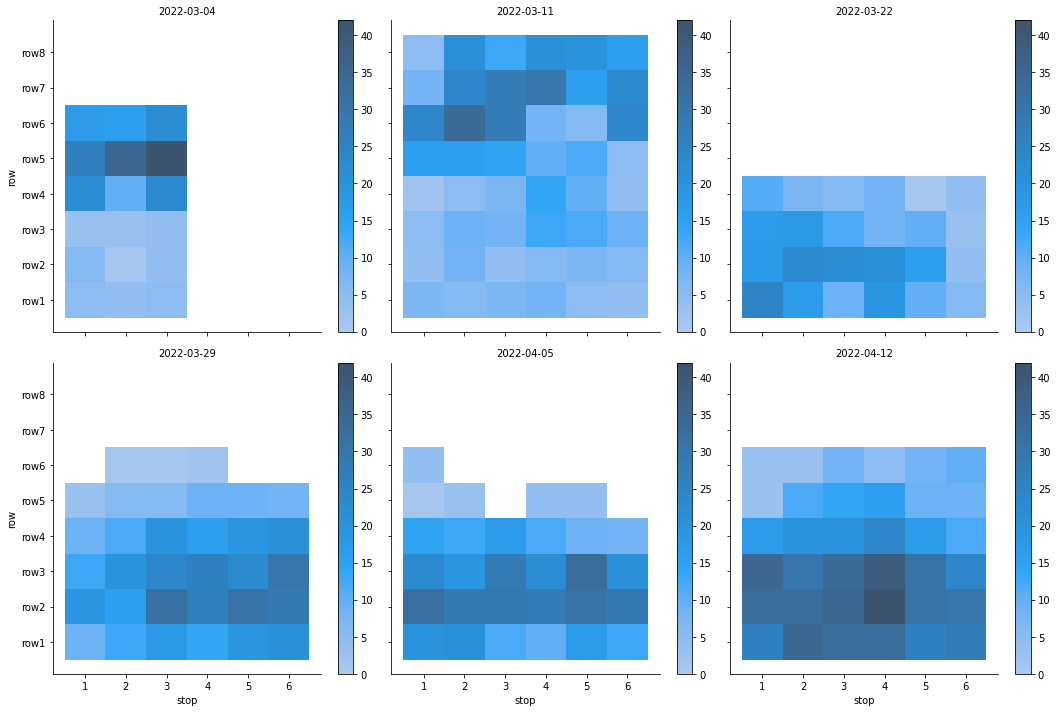

In [12]:
g = sns.displot(
            df.sort_values([ "stop","row"], ascending=(True, False)), 
            x="stop", 
            y="row", 
            cbar=True, 
            col="date",
            
            col_wrap=3, 
            col_order=['2022-03-04', '2022-03-11', '2022-03-22', '2022-03-29', '2022-04-05', '2022-04-12'])
# g.set_axis_labels("Density (a.u.)", "Flipper length (mm)")
g.set_titles("{col_name}")
plt.savefig("kernel_density_by_row_stop.png", dpi=300, format="png", transparent=True)

In [15]:
# df["row"] = df["row"].str.replace("row","").astype("int")
# df["stop"] = df["stop"].astype("int")
# df["row"] = df["row"].astype("int")

<Figure size 2448x1296 with 0 Axes>

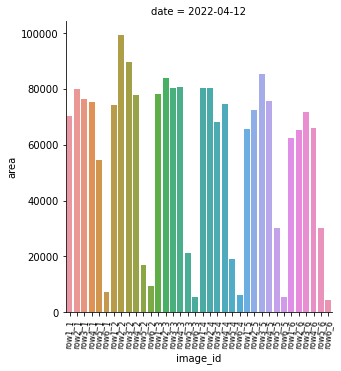

In [16]:
# fig =plt.style.use('fivethirtyeight')
# sns.set_theme(style="dark")
# params = {"ytick.color" : "w",
#           "xtick.color" : "w",
#           "axes.labelcolor" : "w",
#           "axes.titlecolor" : "w",
#           "axes.edgecolor" : "w"}
# plt.rcParams.update(params)
fig =plt.figure(figsize=(34,18))
# fig.set_facecolor("k")

df[["row", "stop"]] = df[["row", "stop"]].astype("str")
im = sns.catplot(data=df[df["date"]=="2022-04-12"].sort_values(["stop","row"], ascending=(True, True)),
                x="image_id", y="area", col="date", 
                kind="bar", dodge=True, ci=None)
im.set_xticklabels(rotation=85, fontsize=8)
# plt.savefig("barplot_Image_area_2022-04-12.png", dpi=300, format="png", transparent=True)

<Figure size 2448x1296 with 0 Axes>

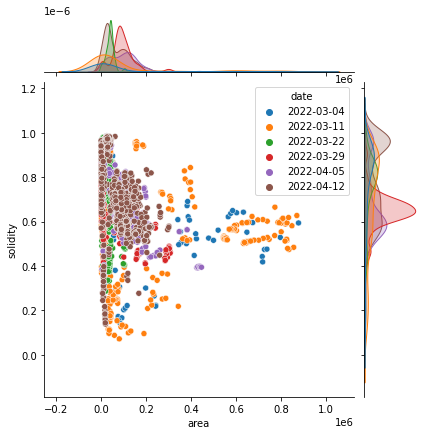

In [17]:
plt.figure(figsize=(34,18))
g = sns.jointplot(data=df, x="area", y="solidity", hue="date")
# plt.savefig("annomaly.png", dpi=300, format="png", transparent=True)


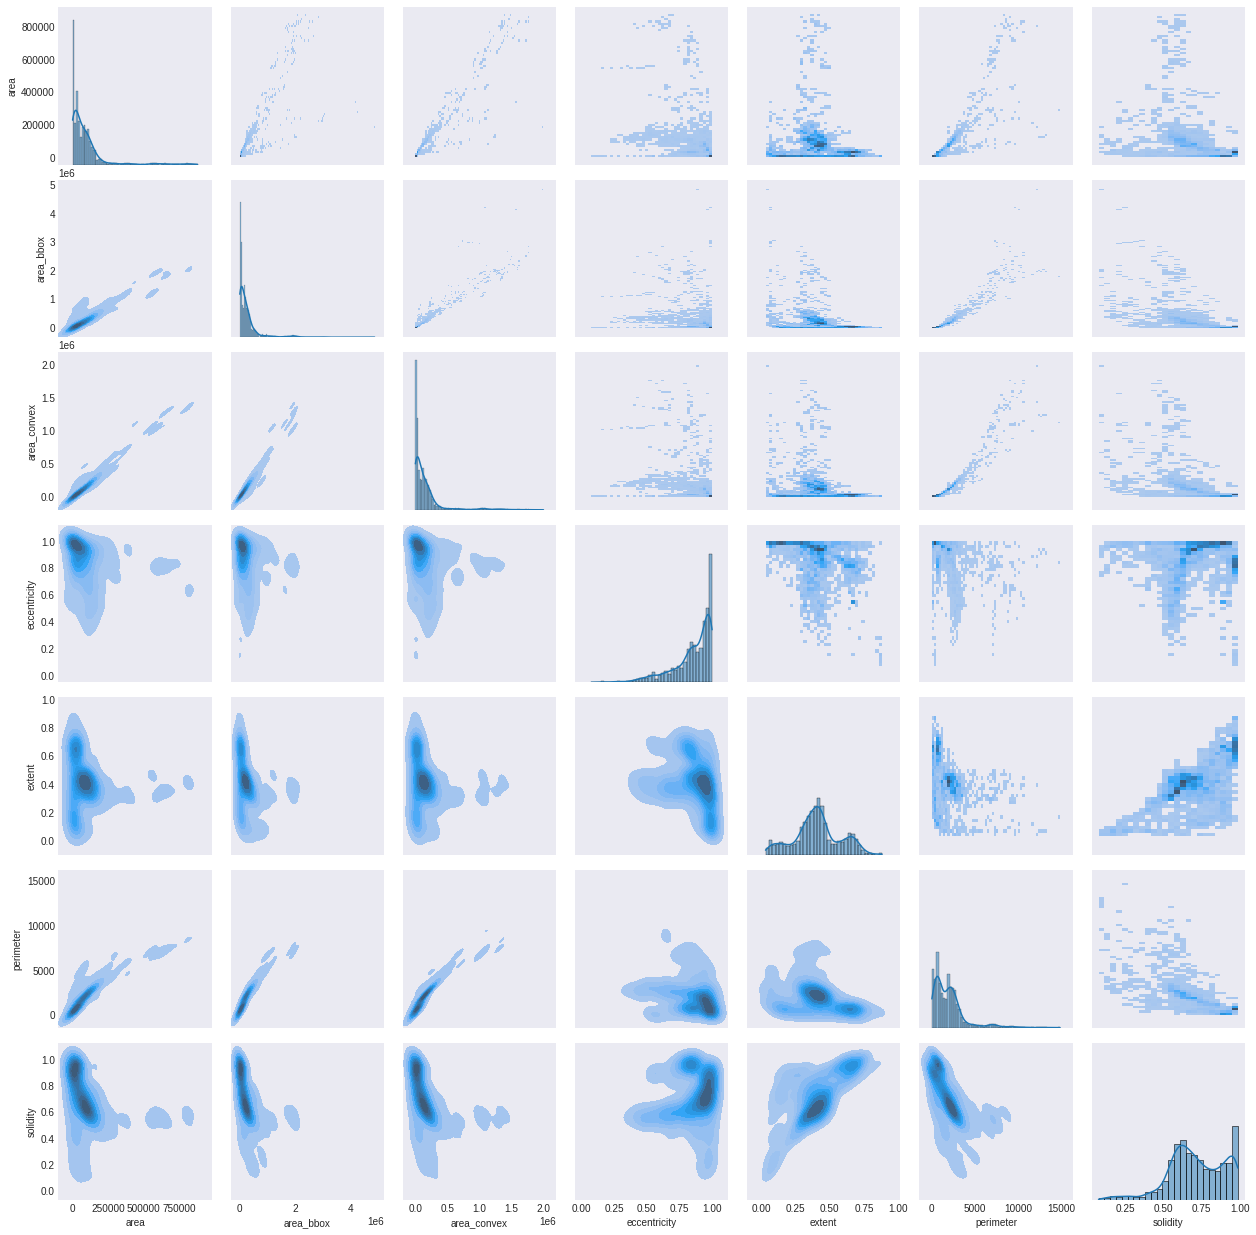

In [36]:
cols_to_norm = ['area','area_bbox', 'area_convex', 'eccentricity', 'extent', 'perimeter', 'solidity']
rdf = df[cols_to_norm]
g = sns.PairGrid(rdf)
g.map_upper(sns.histplot)
g.map_lower(sns.kdeplot, fill=True)
g.map_diag(sns.histplot, kde=True)

# Inspecting Cutouts
A major goal of inspecting the distribution of regional property statistics of cutouts is to identify imbalances.


## Overview of Cutout Stats

Not all statistics are relevant.

`solidity` -  (float) Ratio of pixels in the region to pixels of the convex hull image.

`extent` -  (float) Ratio of pixels in the region to pixels in the total bounding box. Computed as area / (rows * cols)

`area` -  (float) Area of the region i.e. number of pixels of the region scaled by pixel-area.

`area_convex` -  (float) Are of the convex hull image, which is the smallest convex polygon that encloses the region.

`perimeter` -  (float) Perimeter of object which approximates the contour as a line through the centers of border pixels using a 4-connectivity.

`area_bbox` -  (float) Area of the bounding box i.e. number of pixels of bounding box scaled by pixel-area.

`label` -  (int) The label in the labeled input image.


## Inspect distribution

### By Date

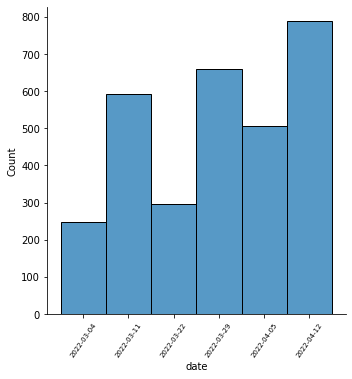

In [18]:
g = sns.displot(df, x="date")
g.set_xticklabels(rotation=55, fontsize=7)
plt.savefig("barplot_number of cutouts by batch.png", dpi=300, format="png", transparent=True)

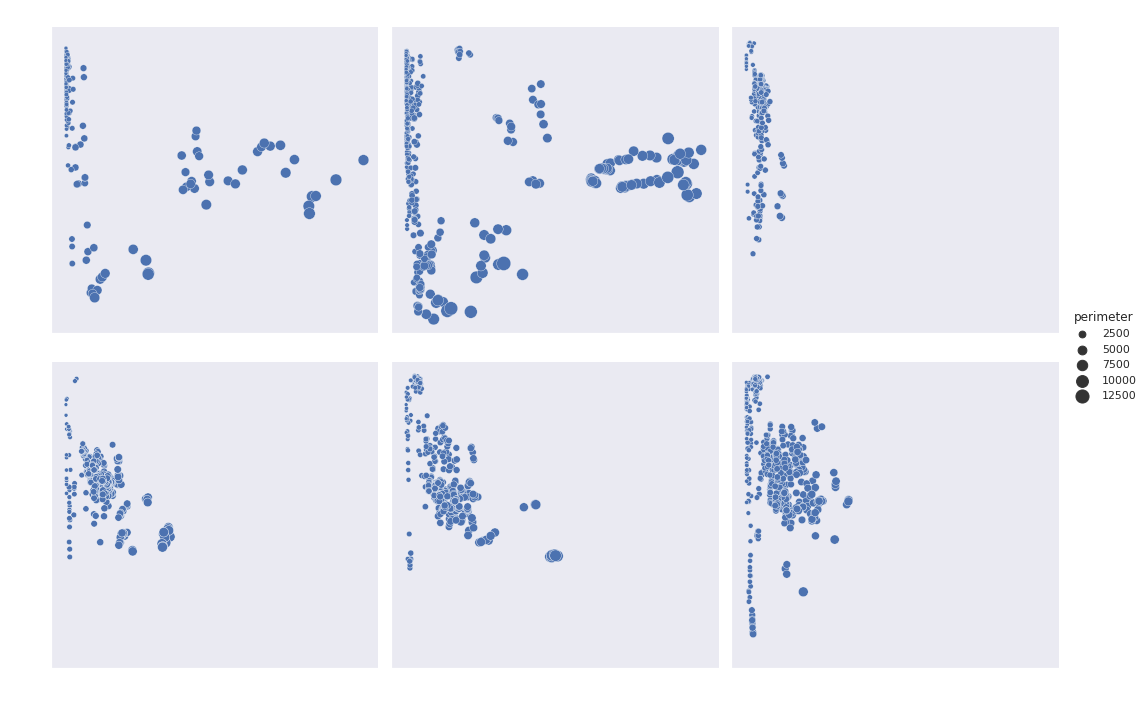

In [170]:
['area','area_bbox', 'area_convex', 'eccentricity', 'extent', 'perimeter', 'solidity']

g = sns.relplot(x="area", y="solidity", size="perimeter",sizes=(15,200), palette="ch:r=-.5,l=.75", data=df, col="date", col_wrap=3)
# g = sns.catplot(x="row", y="area", col="date", kind="bar", data=df.sort_values("row"), sharex=False, col_wrap=3, 
#         col_order=['2022-03-04', '2022-03-11', '2022-03-22', '2022-03-29', '2022-04-05', '2022-04-12'])
(g.set_titles("{col_name}",size=18)
  )  
plt.savefig("barplot_Image_area_anomalies.png", dpi=300, format="png", transparent=True)

/home/admin_mkutugata/miniconda3/envs/autoann/lib/python3.9/site-packages/seaborn/categorical.py:3806: UserWarning: Setting `sharex=False` with `color=None` may cause different levels of the `x` variable to share colors. This will change in a future version.
  warnings.warn(msg.format("sharex", "x"), UserWarning)


<Figure size 2448x1296 with 0 Axes>

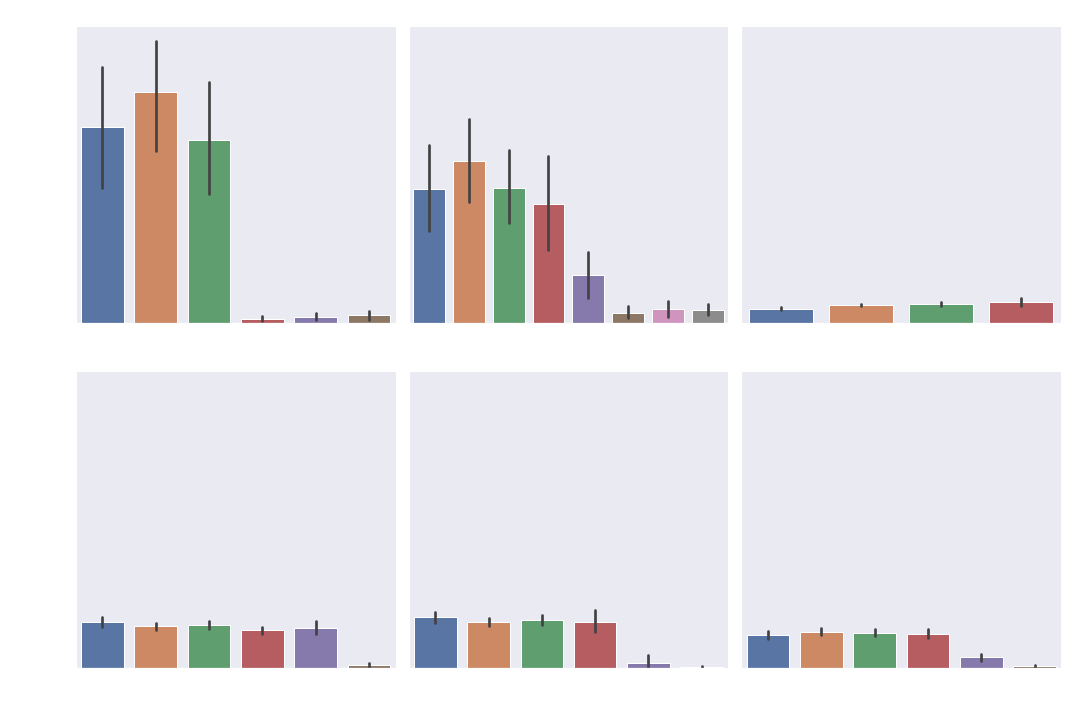

In [166]:

fig =plt.style.use('seaborn-dark')
sns.set_theme(style="dark")
params = {"ytick.color" : "w",
          "xtick.color" : "w",
          "axes.labelcolor" : "w",
          "axes.titlecolor" : "w",
          "axes.edgecolor" : "w"}
plt.rcParams.update(params)
fig =plt.figure(figsize=(34,18))
fig.set_facecolor("k")

g = sns.catplot(x="row", y="area", col="date", kind="bar", data=df.sort_values("row"), sharex=False, col_wrap=3, 
        col_order=['2022-03-04', '2022-03-11', '2022-03-22', '2022-03-29', '2022-04-05', '2022-04-12'])
(g.set_titles("{col_name}",size=18)
  )  

plt.savefig("barplot_Image_area_alldates.png", dpi=300, format="png", transparent=True)

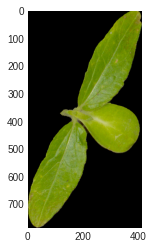

In [112]:
import glob
from pathlib import Path
import random

imgdir = "../data/data/trial/NC_2022-04-05/cutouts"
sm_area = df[df['area']>85000]

sm_area = sm_area[sm_area["date"]=='2022-04-05']
rint = random.randint(0,len(sm_area))
imgps = list(sm_area['cutout_path'])
img = Path(imgdir,imgps[rint])

im = cv2.cvtColor(cv2.imread(str(img)),cv2.COLOR_BGR2RGB)
plt.imshow(im)
plt.show()



In [113]:
sm_area = sm_area[sm_area["date"]=='2022-04-05']
sm_area['area'].mean()

143194.00657894736

In [48]:
!pwd

/home/admin_mkutugata/SemiF-AnnotationPipeline/notebooks
